## Data Cleaning on Motor Vehicle Collisions in NYC

The objective of this work is to show how to handle missing data without having to drop rows and columns using data on motor vehicle collisions released by New York City and published on the [NYC OpenData website](https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95). There is data on over 1.5 million collisions dating back to 2012, with additional data continuously added.

We'll work with an extract of the full data: Crashes from the year 2018. We made several modifications to the data for this purpose, including randomly sampling the data to reduce its size. 

A summary of the columns and their data is below:

  * unique_key: A unique identifier for each collision.
  * date, time: Date and time of the collision.
  * borough: The borough, or area of New York City, where the collision occurred.
  * location: Latitude and longitude coordinates for the collision.
  * on_street, cross_street, off_street: Details of the street or intersection where the collision occurred.
  * pedestrians_injured: Number of pedestrians who were injured.
  * cyclist_injured: Number of people traveling on a bicycle who were injured.
  * motorist_injured: Number of people traveling in a vehicle who were injured.
  * total_injured: Total number of people injured.
  * pedestrians_killed: Number of pedestrians who were killed.
  * cyclist_killed: Number of people traveling on a bicycle who were killed.
  * motorist_killed: Number of people traveling in a vehicle who were killed.
  * total_killed: Total number of people killed.
  * vehicle_1 through vehicle_5: Type of each vehicle involved in the accident.
    cause_vehicle_1 through cause_vehicle_5: Contributing factor for each vehicle in the accident.

Let's read the CSV file into a pandas dataframe and count the number of null values in each of the columns.

## Read Data into a Pandas Dataframe

In [1]:
import pandas as pd
mvc = pd.read_csv("nypd_mvc_2018.csv")
null_counts = mvc.isnull().sum()

## Verify the Total Columns

To give us a better picture of the null values in the data, let's calculate the percentage of null values in each column. Below, we divide the number of null values in each column by the total number of values in the data set:

In [2]:
null_counts_pct = null_counts / mvc.shape[0] * 100

We'll then add both the counts and percentages to a dataframe to make them easier to compare:

In [4]:
null_df = pd.DataFrame({'null_counts': null_counts, 'null_pct': null_counts_pct})
# Rotate the dataframe so that rows become columns and vice-versa
null_df = null_df.T.astype(int)
null_df

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
null_counts,0,0,0,20646,3885,13961,29249,44093,0,0,...,355,12262,54352,57158,57681,175,8692,54134,57111,57671
null_pct,0,0,0,35,6,24,50,76,0,0,...,0,21,93,98,99,0,15,93,98,99


About a third of the columns have no null values, with the rest ranging from less than 1% to 99%!

To make things easier, let's start by looking at the group of columns that relate to people killed in collisions.

We'll use list comprehension to reduce our summary dataframe to just those columns

In [7]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
null_df[killed_cols]

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
null_counts,0,0,0,5
null_pct,0,0,0,0


We can see that each of the individual categories have no missing values, but the total_killed column has five missing values.

One option for handling this would be to remove – or drop – those five rows. This would be a reasonably valid choice since it's a tiny portion of the data, but let's think about what other options we have first.

If you think about it, the total number of people killed should be the sum of each of the individual categories. We might be able to "fill in" the missing values with the sums of the individual columns for that row. It's called imputation. Let's look at how we could explore the values where the total_killed isn't equal to the sum of the other three columns

In [10]:
killed_cols = [col for col in mvc.columns if 'killed' in col]
killed = mvc[killed_cols].copy()
killed_manual_sum = killed.iloc[:,:3].sum(axis=1)
killed_mask = killed_manual_sum != killed['total_killed']
killed_non_eq = killed[killed_mask]
killed_non_eq

,pedestrians_killed,cyclist_killed,motorist_killed,total_killed
3508,0,0,0,NaN
20163,0,0,0,NaN
22046,0,0,1,0.0
48719,0,0,0,NaN
55148,0,0,0,NaN
55699,0,0,0,NaN


## Fill and Verify the Killed and Injured Data

We can categorize these into two categories:

 * Five rows where the total_killed is not equal to the sum of the other columns because the total value is missing.
 * One row where the total_killed is less than the sum of the other columns.

From this, we can conclude that filling null values with the sum of the columns is a fairly good choice for our imputation, given that only six rows out of around 58,000 don't match this pattern.

We've also identified a row that has suspicious data - one that doesn't sum correctly. Once we have imputed values for all rows with missing values for total_killed, we'll mark this suspect row by setting its value to NaN

In [13]:
import numpy as np

# fix the killed values
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'].isnull(), killed_manual_sum)
killed['total_killed'] = killed['total_killed'].mask(killed['total_killed'] != killed_manual_sum, np.nan)

In [12]:
# Create an injured dataframe and manually sum values
injured = mvc[[col for col in mvc.columns if 'injured' in col]].copy()
injured_manual_sum = injured.iloc[:,:3].sum(axis=1)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'].isnull(), injured_manual_sum)
injured['total_injured'] = injured['total_injured'].mask(injured['total_injured'] != injured_manual_sum, np.nan)

## Assign the Corrected Data Back to the main Dataframe

Let's summarize the count of null values before and after our changes:

In [14]:
summary = {
    'injured': [
        mvc['total_injured'].isnull().sum(),
        injured['total_injured'].isnull().sum()
    ],
    'killed': [
        mvc['total_killed'].isnull().sum(),
        killed['total_killed'].isnull().sum()
    ]
}
print(pd.DataFrame(summary, index=['before','after']))

        injured  killed
before        1       5
after        21       0


For the total_killed column, the number of values has gone down from 5 to 1. For the total_injured column, the number of values has actually gone up — from 1 to 21. This might sound like we've done the opposite of what we set out to do, but what we've actually done is fill all the null values and identify values that have suspect data. This will make any analysis we do on this data more accurate in the long run.

Let's assign the values from the killed and injured dataframe back to the main mvc dataframe:

In [15]:
mvc['total_injured'] = injured['total_injured']
mvc['total_killed'] = killed['total_killed']

## Visualize Missing Data with Plots

Earlier, we used a table of numbers to understand the number of missing values in our dataframe. A different approach we can take is to use a plot to visualize the missing values. The function below uses seaborn.heatmap() to represent null values as light squares and non-null values as dark squares:

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
def plot_null_matrix(df, figsize=(18,15)):
    # initiate the figure
    plt.figure(figsize=figsize)
    # create a boolean dataframe based on whether values are null
    df_null = df.isnull()
    # create a heatmap of the boolean dataframe
    sns.heatmap(~df_null, cbar=False, yticklabels=False)
    plt.xticks(rotation=90, size='x-large')
    plt.show()

Let's look at how the function works by using it to plot just the first row of our mvc dataframe. We'll display the first row as a table immediately below so it's easy to compare:

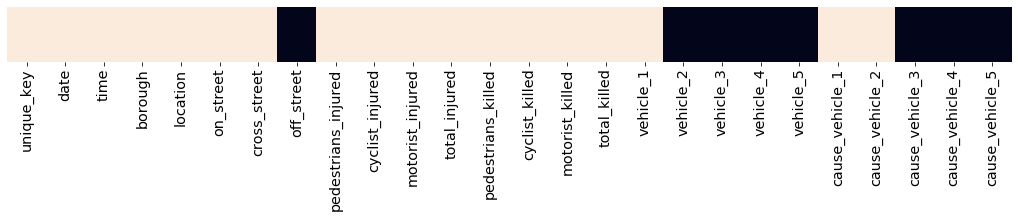

In [18]:
plot_null_matrix(mvc.head(1), figsize=(18,1))

In [20]:
mvc.head(1)

,unique_key,date,time,borough,location,on_street,cross_street,off_street,pedestrians_injured,cyclist_injured,...,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,3869058,2018-03-23,21:40,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,10 AVENUE,NaN,0,0,...,PASSENGER VEHICLE,NaN,NaN,NaN,NaN,Following Too Closely,Unspecified,NaN,NaN,NaN


Each value is represented by a dark square, and each missing value is represented by a light square.

Let's look at what a plot matrix looks like for the whole dataframe:

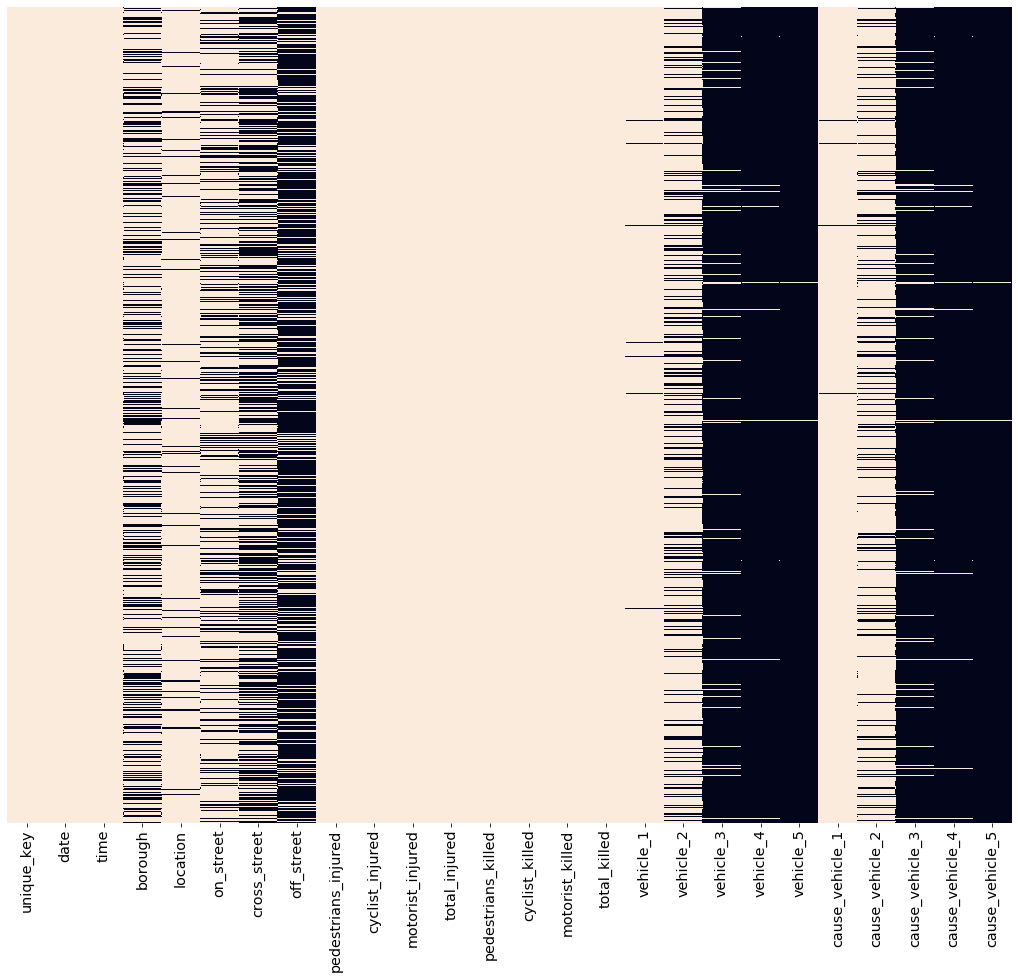

In [21]:
plot_null_matrix(mvc)

We can make some immediate interpretations about our dataframe:

  * The first three columns have few to no missing values.
  * The next five columns have missing values scattered throughout, with each column seeming to have its own density of missing values.
  * The next eight columns are the injury and killed columns we just cleaned, and only have a few missing values.
  * The last 10 columns seem to break into two groups of five, with each group of five having similar patterns of null/non-null values.

Let's examine the pattern in the last 10 columns a little more closely. We can calculate the relationship between two sets of columns, known as correlation


In [23]:
cols_with_missing_vals = mvc.columns[mvc.isnull().sum() > 0]
missing_corr = mvc[cols_with_missing_vals].isnull().corr()
missing_corr

,borough,location,on_street,cross_street,off_street,total_injured,vehicle_1,vehicle_2,vehicle_3,vehicle_4,vehicle_5,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
borough,1.000000,0.190105,-0.350190,0.409107,0.362189,-0.002827,-0.018325,-0.077516,-0.061932,-0.020406,-0.010733,-0.012115,-0.058596,-0.060542,-0.020158,-0.011348
location,0.190105,1.000000,-0.073975,-0.069719,0.084579,-0.001486,-0.010466,-0.033842,-0.000927,0.004655,-0.005797,-0.003458,-0.021373,0.000684,0.004604,-0.004841
on_street,-0.350190,-0.073975,1.000000,0.557767,-0.991030,0.006220,-0.001889,0.119647,0.020867,0.004172,-0.002768,0.001307,0.087374,0.017426,0.002737,-0.003107
cross_street,0.409107,-0.069719,0.557767,1.000000,-0.552763,0.002513,-0.017018,0.043799,-0.049910,-0.021137,-0.012003,-0.009102,0.031189,-0.052159,-0.022074,-0.013455
off_street,0.362189,0.084579,-0.991030,-0.552763,1.000000,-0.004266,0.001812,-0.121129,-0.022404,-0.004074,0.002492,-0.001738,-0.088187,-0.019120,-0.002580,0.002863
total_injured,-0.002827,-0.001486,0.006220,0.002513,-0.004266,1.000000,0.079840,0.025644,-0.002757,0.002118,0.001073,0.131140,0.030082,-0.002388,0.002188,0.001102
vehicle_1,-0.018325,-0.010466,-0.001889,-0.017018,0.001812,0.079840,1.000000,0.151516,0.019972,0.008732,0.004425,0.604281,0.180678,0.020624,0.009022,0.004545
vehicle_2,-0.077516,-0.033842,0.119647,0.043799,-0.121129,0.025644,0.151516,1.000000,0.131813,0.057631,0.029208,0.106214,0.784402,0.132499,0.058050,0.029264
vehicle_3,-0.061932,-0.000927,0.020867,-0.049910,-0.022404,-0.002757,0.019972,0.131813,1.000000,0.437214,0.221585,0.014000,0.106874,0.961316,0.448525,0.225067
vehicle_4,-0.020406,0.004655,0.004172,-0.021137,-0.004074,0.002118,0.008732,0.057631,0.437214,1.000000,0.506810,0.006121,0.046727,0.423394,0.963723,0.515058


Each value is between -1 and 1, and represents the relationship between two columns. A number close to -1 or 1 represents a strong relationship, where a number in the middle (close to 0) represents a weak relationship.

If you look closely, you can see a diagonal line of 1s going from top left to bottom right. These values represent each columns relationship with itself, which of course is a perfect relationship. The values on the top/right of this "line of 1s" mirror the values on the bottom/left of this line: The table actually repeats every value twice!

Correlation tables can be hard to interpret. We can convert our table into a plot which will make this a lot easier. Let's see what this plot looks like





## Analyse Correlations in Missing Data

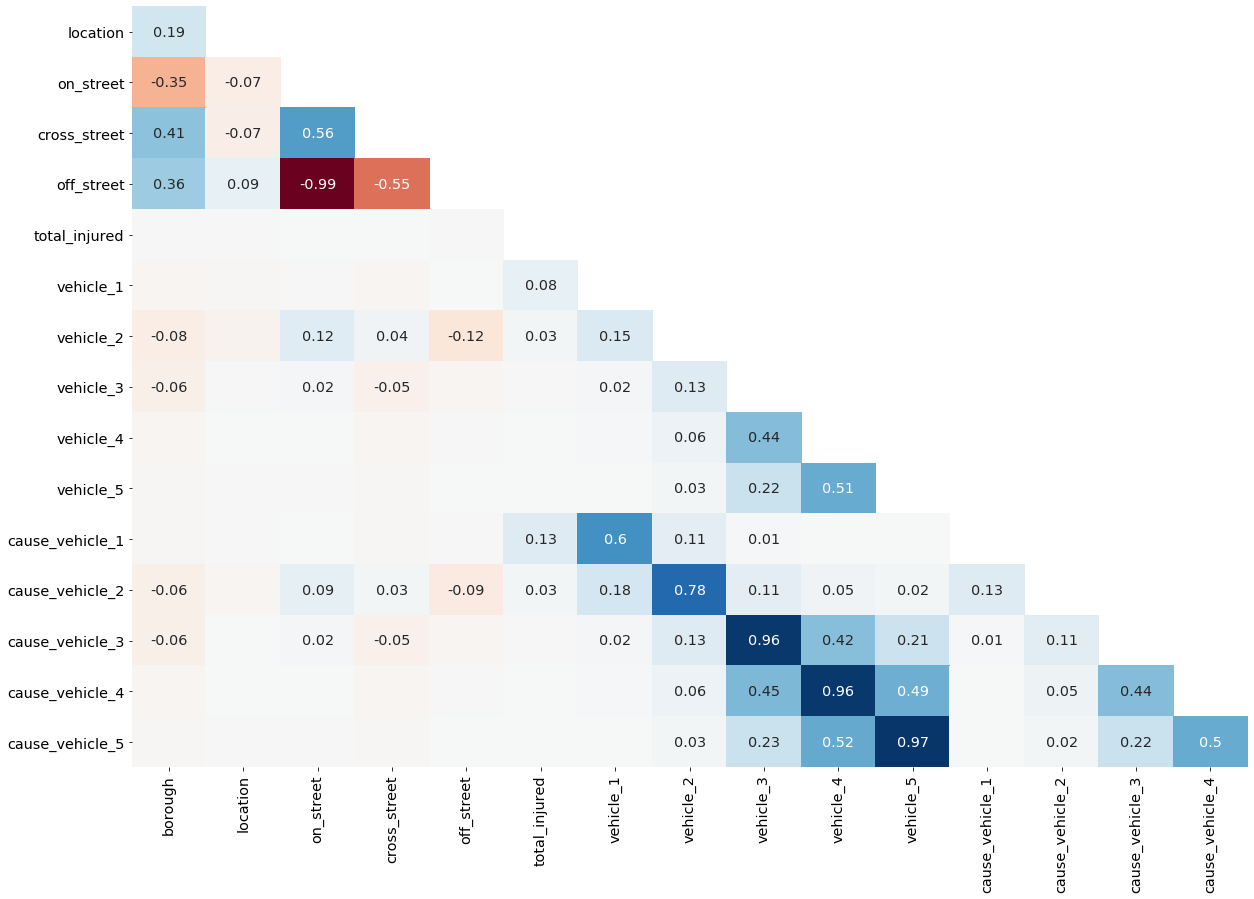

In [29]:
def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = mvc.columns[mvc.isnull().sum() > 0]
    missing_corr = mvc[cols_with_missing_vals].isnull().corr()
   
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()

veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

In our correlation plot:

   * The "line of 1s" and the repeated values are removed so that it's not visually overwhelming.
   * Values very close to 0, where there is little to no relationship, aren't labeled.
   * Values close to 1 are dark blue and values close to -1 are dark red — the depth of color represents the strength of the relationship.

Let's create a correlation plot of just those last 10 columns to see if we can more closely identify the pattern we saw earlier in the matrix plot.

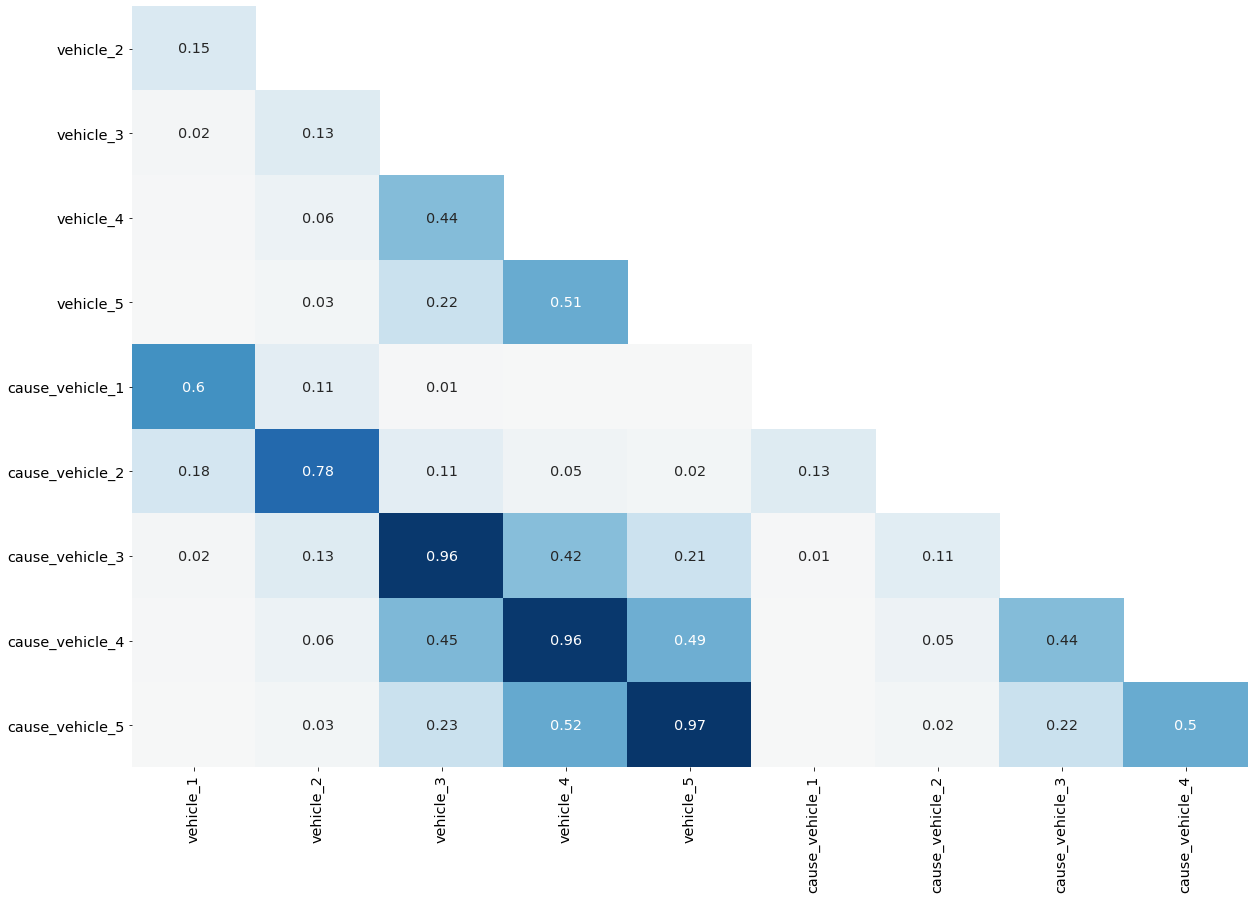

In [31]:
def plot_null_correlations(df):
    # create a correlation matrix only for columns with at least
    # one missing value
    cols_with_missing_vals = df.columns[df.isnull().sum() > 0]
    missing_corr = df[cols_with_missing_vals].isnull().corr()
    
    # create a triangular mask to avoid repeated values and make
    # the plot easier to read
    missing_corr = missing_corr.iloc[1:, :-1]
    mask = np.triu(np.ones_like(missing_corr), k=1)
    
    # plot a heatmap of the values
    plt.figure(figsize=(20,14))
    ax = sns.heatmap(missing_corr, vmin=-1, vmax=1, cbar=False,
                     cmap='RdBu', mask=mask, annot=True)
    
    # format the text in the plot to make it easier to read
    for text in ax.texts:
        t = float(text.get_text())
        if -0.05 < t < 0.01:
            text.set_text('')
        else:
            text.set_text(round(t, 2))
        text.set_fontsize('x-large')
    plt.xticks(rotation=90, size='x-large')
    plt.yticks(rotation=0, size='x-large')

    plt.show()
veh_cols = [c for c in mvc.columns if 'vehicle' in c]
plot_null_correlations(mvc[veh_cols])

The pairs of column names that have a higher correlation than the rest are:

    vehicle_1 and cause_vehicle_1
    vehicle_2 and cause_vehicle_2
    vehicle_3 and cause_vehicle_3
    vehicle_4 and cause_vehicle_4
    vehicle_5 and cause_vehicle_5

If you think about it, this makes sense. When a vehicle is in an accident, there is likely to be a cause, and vice-versa.

Let's explore the variations in missing values from these five pairs of columns. We'll create a dataframe that counts, for each pair:

    The number of values where the vehicle is missing when the cause is not missing.
    The number of values where the cause is missing when the vehicle is not missing.



In [34]:
col_labels = ['v_number', 'vehicle_missing', 'cause_missing']

vc_null_data = []

# for v in range(1,6):
#     v_col = 'vehicle_{}'.format(v)
#     c_col = 'cause_vehicle_{}'.format(v)
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_null = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
    c_null = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()
    
    vc_null_data.append([v, v_null, c_null])

vc_null_df = pd.DataFrame(vc_null_data, columns=col_labels)
vc_null_df

,v_number,vehicle_missing,cause_missing
0,1,204,24
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


## Find the Most Common Value Across Multiple Columns

The analysis we did on the previous screen indicates that there are roughly 4,500 missing values across the 10 columns. The easiest option for handling these would be to drop the rows with missing values. This would mean losing almost 10% of the total data, which is something we ideally want to avoid.

A better option is to impute the data, like we did earlier. Because the data in these columns is text data, we can't perform a numeric calculation to impute missing data like we did with the injuries and killed columns.

One common option when imputing is to use the most common value to fill in data. Let's look at the common values across these columns and see if we can use that to make a decision.

In [38]:
cause_cols = [c for c in mvc.columns if "cause_" in c]
cause = mvc[cause_cols]
cause.head()

,cause_vehicle_1,cause_vehicle_2,cause_vehicle_3,cause_vehicle_4,cause_vehicle_5
0,Following Too Closely,Unspecified,NaN,NaN,NaN
1,Backing Unsafely,Unspecified,NaN,NaN,NaN
2,Following Too Closely,Unspecified,NaN,NaN,NaN
3,Glare,Passing Too Closely,NaN,NaN,NaN
4,Turning Improperly,Unspecified,NaN,NaN,NaN


Next, we'll stack the values into a single series object:

In [39]:
cause_1d = cause.stack()
cause_1d.head()

0  cause_vehicle_1    Following Too Closely
   cause_vehicle_2              Unspecified
1  cause_vehicle_1         Backing Unsafely
   cause_vehicle_2              Unspecified
2  cause_vehicle_1    Following Too Closely
dtype: object

Finally, we count the values in the series

In [40]:
cause_counts = cause_1d.value_counts()
top10_causes = cause_counts.head(10)
print(top10_causes)

Unspecified                       57481
Driver Inattention/Distraction    17650
Following Too Closely              6567
Failure to Yield Right-of-Way      4566
Passing or Lane Usage Improper     3260
Passing Too Closely                3045
Backing Unsafely                   3001
Other Vehicular                    2523
Unsafe Lane Changing               2372
Turning Improperly                 1590
dtype: int64


The most common non-null value for the cause columns is Unspecified, which presumably indicates that the officer reporting the collision was unable to determine the cause for that vehicle.

Let's use the same technique to identify the most common non-null value for the vehicle columns.

In [36]:
v_cols = [c for c in mvc.columns if c.startswith("vehicle")]
vehicles = mvc[v_cols]
vehicles_1d = vehicles.stack()
vehicles_counts = vehicles_1d.value_counts()
top10_vehicles = vehicles_counts.head(10)
top10_vehicles

Sedan                                  33133
Station Wagon/Sport Utility Vehicle    26124
PASSENGER VEHICLE                      16026
SPORT UTILITY / STATION WAGON          12356
Taxi                                    3482
Pick-up Truck                           2373
TAXI                                    1892
Box Truck                               1659
Bike                                    1190
Bus                                     1162
dtype: int64

## Fill Unknown Values with a Placeholder

The top "cause" is an "Unspecified" placeholder. This is useful instead of a null value as it makes the distinction between a value that is missing because there were only a certain number of vehicles in the collision versus one that is because the contributing cause for a particular vehicle is unknown.

The vehicles columns don't have an equivalent, but we can still use the same technique. Here's the logic we'll need to do for each pair of vehicle/cause columns:

  * For values where the vehicle is null and the cause is non-null, set the vehicle to Unspecified.
  * For values where the cause is null and the vehicle is not-null, set the cause to Unspecified.

Let's do this for the vehicle_1 and vehicle_cause_1 columns


In [43]:
# create a mask for each column
v_missing_mask = mvc['vehicle_1'].isnull() & mvc['cause_vehicle_1'].notnull()
c_missing_mask = mvc['cause_vehicle_1'].isnull() & mvc['vehicle_1'].notnull()

# replace the values matching the mask for each column
mvc['vehicle_1'] =  mvc['vehicle_1'].mask(v_missing_mask, "Unspecified")
mvc['cause_vehicle_1'] =  mvc['cause_vehicle_1'].mask(c_missing_mask, "Unspecified")

def summarize_missing():
    v_missing_data = []

    for v in range(1,6):
        v_col = 'vehicle_{}'.format(v)
        c_col = 'cause_vehicle_{}'.format(v)

        v_missing = (mvc[v_col].isnull() & mvc[c_col].notnull()).sum()
        c_missing = (mvc[c_col].isnull() & mvc[v_col].notnull()).sum()

        v_missing_data.append([v, v_missing, c_missing])

    col_labels = columns=["vehicle_number", "vehicle_missing", "cause_missing"]
    return pd.DataFrame(v_missing_data, columns=col_labels)
summarize_missing()

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,3793,223
2,3,242,24
3,4,50,3
4,5,10,0


In [45]:
summary_before = summarize_missing()

for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
for v in range(1,6):
    v_col = 'vehicle_{}'.format(v)
    c_col = 'cause_vehicle_{}'.format(v)
    
    v_missing_mask = mvc[v_col].isnull() & mvc[c_col].notnull()
    c_missing_mask = mvc[c_col].isnull() & mvc[v_col].notnull()

    mvc[v_col] = mvc[v_col].mask(v_missing_mask, "Unspecified")
    mvc[c_col] = mvc[c_col].mask(c_missing_mask, "Unspecified")

summary_after = summarize_missing()
summary_after

,vehicle_number,vehicle_missing,cause_missing
0,1,0,0
1,2,0,0
2,3,0,0
3,4,0,0
4,5,0,0


## Missing Data in the 'Location' Columns

Let's now turn our focus to the final set of columns that contain missing values — the columns that relate to the location of the accident. We'll start by looking at the first few rows to refamiliarize ourselves with the data:

In [47]:
loc_cols = ['borough', 'location', 'on_street', 'off_street', 'cross_street']
location_data = mvc[loc_cols]
location_data.head()

,borough,location,on_street,off_street,cross_street
0,MANHATTAN,"(40.742832, -74.00771)",WEST 15 STREET,NaN,10 AVENUE
1,BROOKLYN,"(40.623714, -73.99314)",16 AVENUE,NaN,62 STREET
2,NaN,"(40.591755, -73.9083)",BELT PARKWAY,NaN,NaN
3,QUEENS,"(40.73602, -73.87954)",GRAND AVENUE,NaN,VANLOON STREET
4,BRONX,"(40.884727, -73.89945)",NaN,208 WEST 238 STREET,NaN


Next, let's look at counts of the null values in each column:


In [49]:
location_data.isnull().sum()


borough         20646
location         3885
on_street       13961
off_street      44093
cross_street    29249
dtype: int64



These columns have a lot of missing values! Keep in mind that all of these five columns represent the same thing — the location of the collision. We can potentially use the non-null values to impute some of the null values.

To see where we might be able to do this, let's look for correlations between the missing values:


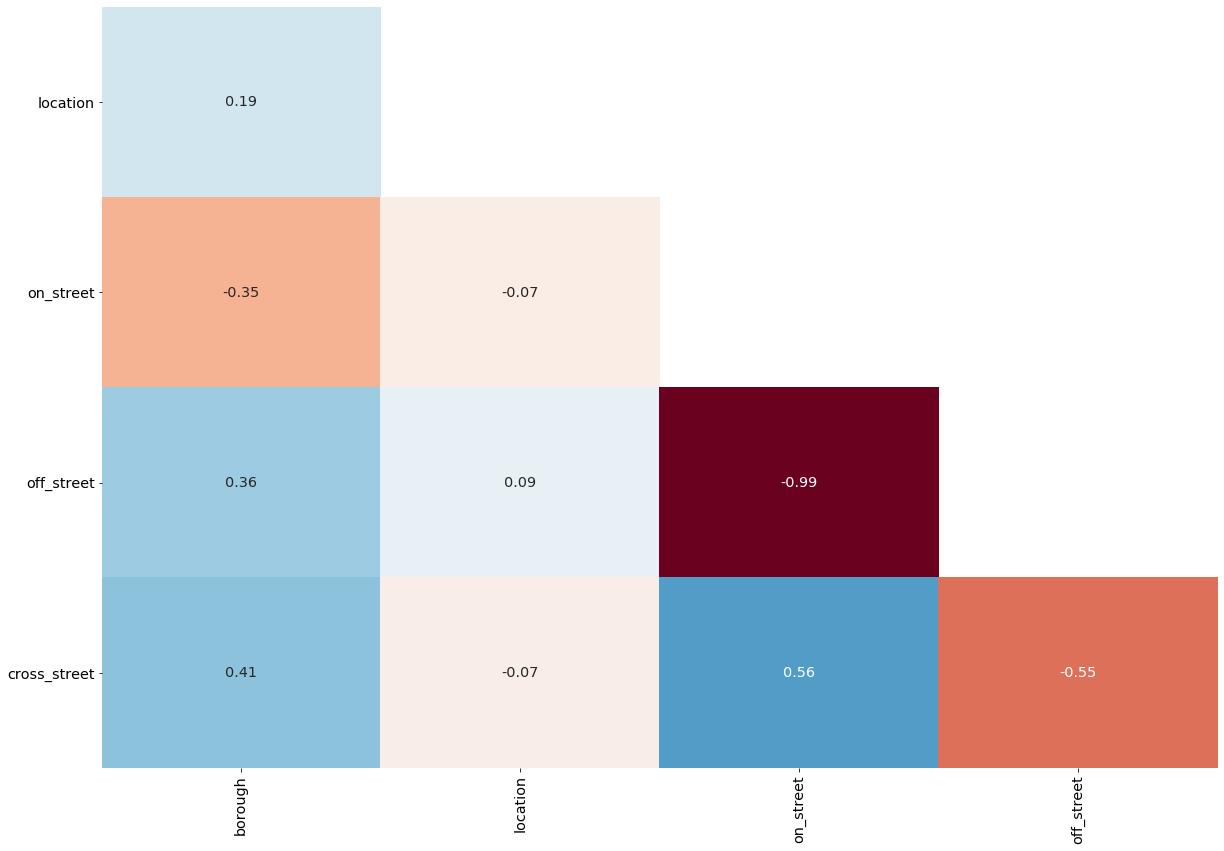

In [50]:
plot_null_correlations(location_data)

None of these columns have strong correlations except for off_street and on_street which have a near perfect negative correlation. That means for almost every row that has a null value in one column, the other has a non-null value and vice-versa.

The final way we'll look at the null values in these columns is to plot a null matrix, but we'll sort the data first. This will gather some of the null and non-null values together and make patterns more obvious:

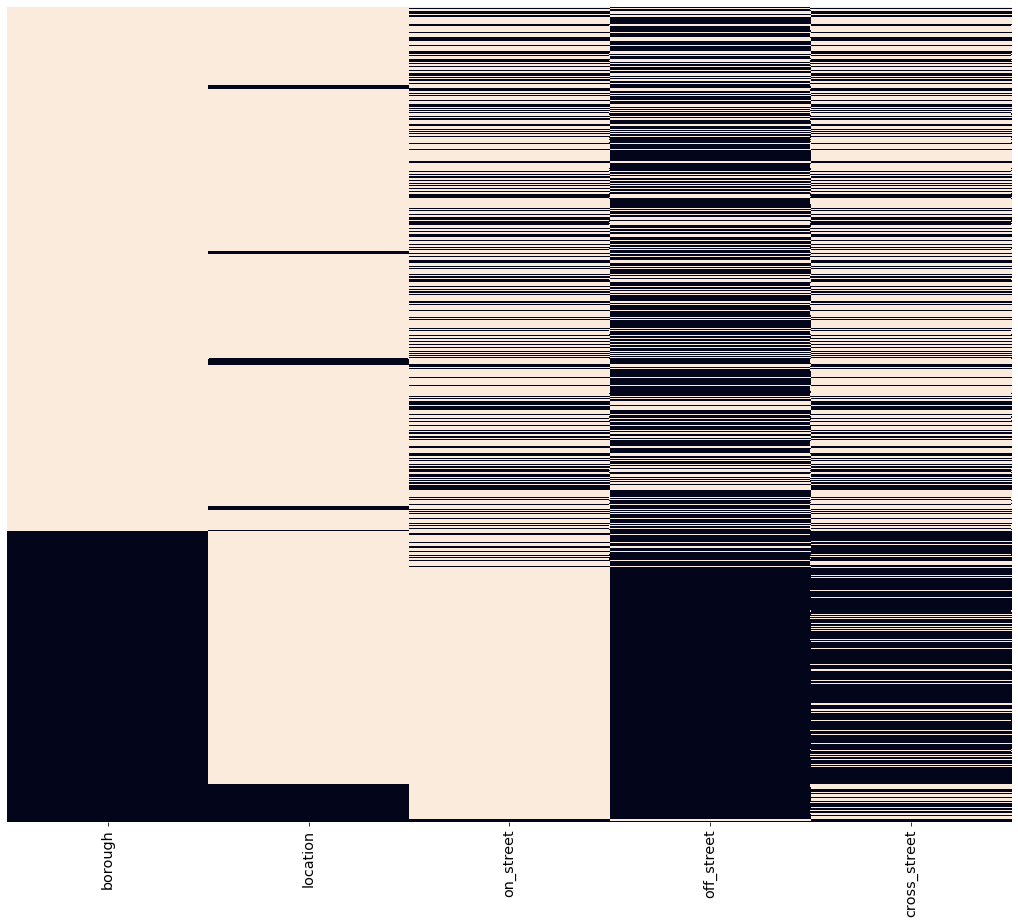

In [51]:
sorted_location_data = location_data.sort_values(loc_cols)
plot_null_matrix(sorted_location_data)

Let's make some observations about the missing values across these columns:

   * About two-thirds of rows have non-null values for borough, but of those values that are missing, most have non-null values for location and one or more of the street name columns.
   * Less than one-tenth of rows have missing values in the location column, but most of these have non-null values in one or more of the street name columns.
   * Most rows have a non-null value for either on_street or off_street, and some also have a value for cross_street.

Combined, this means that we will be able to impute a lot of the missing values by using the other columns in each row. To do this, we can use geolocation APIs that take either an address or location coordinates, and return information about that location.



## Imputing Location Data

Because the focus of this project is working with missing data, we have pre-prepared supplemental data using APIs. We prepared the supplemental data using the GeoPy package, which makes working with Geocoding APIs like the Google Maps API easier. Here's the strategy we used to prepare the supplemental data:

  * For rows with location values but missing values in either borough or the street name columns, we used geocoding APIs to look up the location coordinates to find the missing data.
  * For rows with values in the street name columns missing borough and/or location data, we used geocoding APIs to look up the address to find the missing data.

The supplemental data is in a CSV called supplemental_data.csv, let's read this into a pandas dataframe and familiarize ourself with the data:


In [52]:
sup_data = pd.read_csv('supplemental_data.csv')
sup_data.head()

,unique_key,location,on_street,off_street,borough
0,3869058,NaN,NaN,NaN,NaN
1,3847947,NaN,NaN,NaN,NaN
2,3914294,NaN,BELT PARKWAY,NaN,BROOKLYN
3,3915069,NaN,NaN,NaN,NaN
4,3923123,NaN,NaN,NaN,NaN


The supplemental data has five columns from our original data set — the unique_key that identifies each collision, and four of the five location columns. The cross_street column is not included because the geocoding APIs we used don't include data on the nearest cross street to any single location.

Let's take a look at a null matrix for the supplemental data:

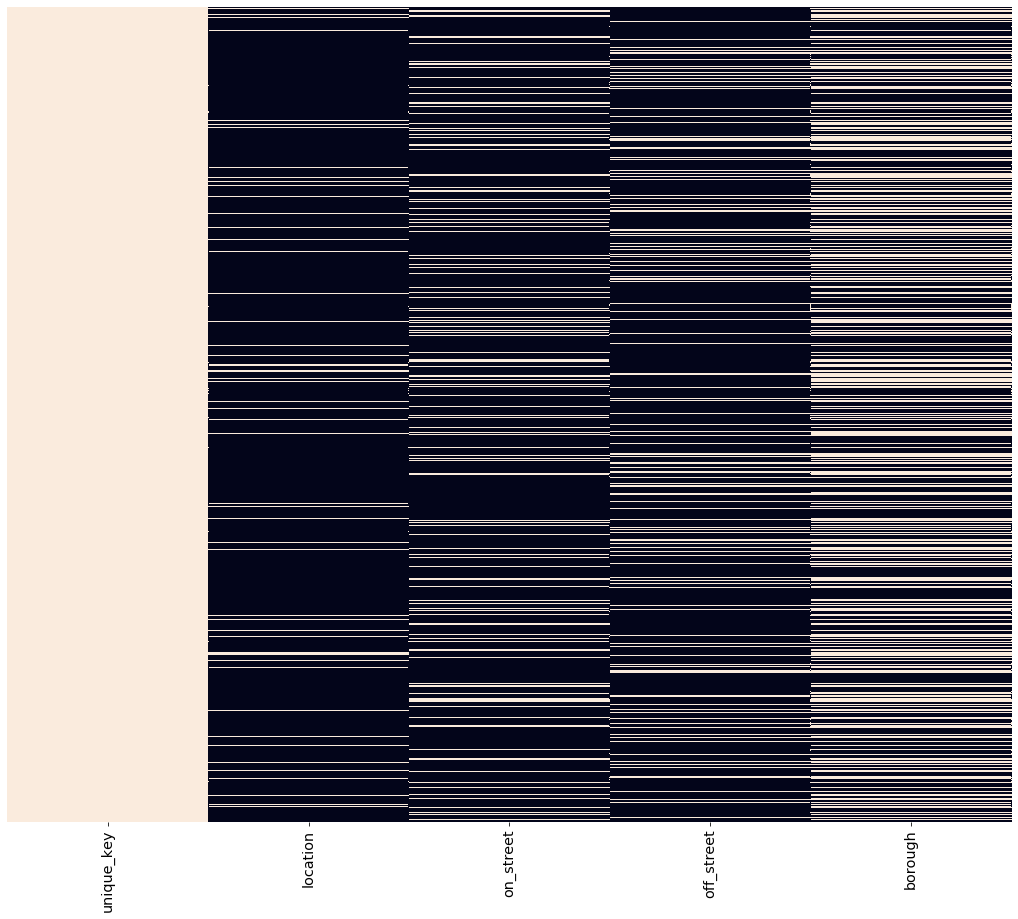

In [53]:
plot_null_matrix(sup_data)

Apart from the unique_key column, you'll notice that there are a lot more missing values than our main data set. This makes sense, as we didn't prepare supplemental data where the original data set had non-null values.

If the unique_key column in both the original and supplemental data has the same values in the same order, we'll be able to to add our supplemental data to our original data. Let's Check

In [54]:
mvc_keys = mvc['unique_key']
sup_keys = sup_data['unique_key']

is_equal = mvc_keys.equals(sup_keys)
print(is_equal)

True


Now that we've verified the data, it's time to use it to impute missing values.

In [56]:
sup_data = pd.read_csv('supplemental_data.csv')

location_cols = ['location', 'on_street', 'off_street', 'borough']
null_before = mvc[location_cols].isnull().sum()
for col in location_cols:
    mvc[col] = mvc[col].mask(mvc[col].isnull(), sup_data[col])

null_after = mvc[location_cols].isnull().sum()
null_after 

location         77
on_street     13734
off_street    36131
borough         232
dtype: int64